In [1]:
from sage.graphs.connectivity import *
from sage.graphs.graph_input import from_graph6
from sage.matroids.advanced import *
from sage.matroids.advanced import setprint
from sage.graphs.trees import TreeIterator

In [2]:
load("https://raw.githubusercontent.com/jephianlin/minrank_aux/master/load_all.py")

xrange test passed


In [3]:
load_all()

Loading Zq_c.pyx...


Compiling /home/sage/.sage/temp/Coleman/846/tmp_tw27Ol.pyx...


Loading Zq.py...
Loading zero_forcing_64.pyx...


Compiling /home/sage/.sage/temp/Coleman/846/tmp_bpxS2i.pyx...


Loading zero_forcing_wavefront.pyx...


Compiling /home/sage/.sage/temp/Coleman/846/tmp_8sYA5I.pyx...


Loading minrank.py...
Loading inertia.py...
Loading general_Lib.sage...
---sshow, multi_sshow, tuple_generator, minimal_graphs, empty_array, all_one_matrix, elementary_matrix, eigens_multi, sort_dictionary, has_minor, etc.
Loading oc_diag_analysis.sage...
---gZ_leq, find_gZ, find_EZ, diagonal_analysis, etc.
Loading xi_dict.py...
---SAPreduced_matrix, has_SAP, find_ZFloor, Zsap, etc.
Loading mu_dict.py...
---get_mu_from_dict, find_mu, etc.
Loading SXP.sage...
This code contains extra copy of Z_game, Zell_game, Zplus_game, for the completeness of Zsap_game program.
Loading matrix_forcing.py...


In [4]:
def All_Forts(G):
# input the connected graph G
# ouput the set of forts of g
    V = G.vertices()
    S = Subsets(V)
    Forts = set(S)
    for s in S:
        for x in set(V) - set(s):
            if len(list((set(G.neighbors(x)) & set(s))))==1:
                Forts.remove(s)
                break
        if len(list(s))==0:
            Forts.remove(s)
    #print 'total number of forts = ', len(Forts)
    F = sorted([sorted(list(f)) for f in Forts],key=len)
    return F;   

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list, tuple)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

#Input: a symmetric matrix A ( could also do combinatorially symmetric by slight alteration )
#Output: Graphs G' where A in S(G) can be lifted to by adding a vertex and where there exists a matrix in S(G') with the same rank 
def Col_Supp_Lifts(A):
    
    #print 'rank = ', A.rank(), '\n'
    #print A, '\n'
    #n number of rows/columns in A
    n=len(list(A))
    
    #constructing the graph for A
    #print 'G(A) = '
    G=Graph([])
    G.add_vertices(range(n))
    for i in range(0,n):
        for j in range(i+1,n):
            if A[i][j] != 0:
                G.add_edge((i,j))
    #G.show()
    
    #print '===========================================================', '\n', 'Minimal support lifts for A ', '\n'

    #requires sage matroid package, sage.matroids.advanced import *
    kerA=Matrix(A.kernel().basis())

    #Computing matroid data for the null space of the null space

    M=Matroid(kerA)
    # The list of circuits for ker(A).  This should be the minimal supports of the column space.
    CM=sorted([sorted(C) for C in M.circuits()])
    #print CM

#     for i in range(len(CM)):
#         H=deepcopy(G)
#         H.add_vertex(7)
#         for j in range(len(CM[i])):
#             H.add_edges([(7,CM[i][j])])
        #H.show()
        #print H.graph6_string(), ' with neighbors of 7 ', CM[i]
        
    #Construct all unions of supports in CM
    N=[i for i in range(len(CM))]
    S=[list(s) for s in subsets(N)]
    #print 'number of unions of column supports = ', len(S)

    # m=3500
    # print S[m], '\n'
    # U=[CM[k] for k in S[m]]
    # print list(set(flatten(U)))

    L=[]


    for j in range(len(S)):
         for k in range(len(S[j])):
            U=[CM[k] for k in S[j]]
            fU=list( set( flatten(U)))
            print fU
            H=deepcopy(G)
            H.add_vertex(7)
            for i in range(len(fU)):
                H.add_edges([(7,fU[i])])
            #H.show()
            #print H.graph6_string()
            L.append(H.graph6_string())
    #Gets rid of duplicates in L
    L_new = list(set(L))

    m=len(L_new)
    L_new_remove=[]
    for i in range(m):
        for j in range(i+1,m):
            if Graph(L_new[i]).is_isomorphic(Graph(L_new[j])):
                L_new_remove.append(L_new[j])
    #print 'number of unique unions = ', len(L_new)
    L_new_new = list( set(L_new).difference( set(L_new_remove)) )
    #print 'number of non-isomorphic lifting graphs = ', len( L_new_new )
    #print list( L_new_new )
    
    return L_new_new;


#input: list of Sets, U
#output: list of Sets that are unions minus one element of pairs of Sets in U in the intersection per circuit exchange property
def ExchangeUnions(U):
    lenU=len(U)
    NewUnions=[]

    for j1 in range(lenU):
        for j2 in range(j1+1,lenU):
            union=U[j1].union(U[j2])
            inter=U[j1].intersection(U[j2])

            if len(inter)>0:
                for x in inter:
                    NewUnions.append(union.difference({x}))

    NewUnionsSet=list(set(NewUnions)) 
    
    return(NewUnionsSet)

#input: list of Sets, F
#output: list of pairs of indices of Sets in F for which the exchange property for circuits fundamentally fails on the input

def BadPairs(F):

    n=len(F)
    BadPairs=[]
    
    for i in range(n):
        for j in range(i+1,n):
            union=F[i].union(F[j])
            inter=F[i].intersection(F[j])

            #for i in range(m):
            if len(inter)>0:
                for x in inter:
                    N=union.difference({x})
                    #print i,j,N, F[i], F[j]
                    for f in F:
                        if (not( any( f.issubset(N) for f in F) ) ):
                            BadPairs.append(Set([i,j]))
                            #print 'bad pair'
                            #print i,j, N, F[i],F[j]
                            break;


    return(BadPairs) 


#input: list of Sets, U
#output: list of Sets that are unions minus one element of pairs of Sets in U in the intersection per circuit exchange property
def ExchangeUnionsIndices(U,A):
    NewUnionsIndices=[]
    
    EU=ExchangeUnions(U)
    lenEU=len(EU)
    
    for i in range(lenEU):
        Indices=[]
        for a in A:
            if a.issubset(EU[i]):
                Indices.append(A.index(a))
        NewUnionsIndices.append(Indices)
    

    
    
    return(NewUnionsIndices)


#input: size of transversal 4, list of Sets F
#output:  list of indices for F with unique representatives of a minimum transversal of size 4 
def GoodIndices4(F):
    m=len(F)
    UniqFortRepIndex=Subsets(range(m),4)
    lenUFRI=len(UniqFortRepIndex)
    
    
    GoodIndices=[]
    

    for i in range(lenUFRI):
        U=[F[k] for k in UniqFortRepIndex[i]]
        #print U
        uniq=[]
        #if U[0] in U[1].union(U[2]).union(U[3])
        for x0 in U[0]:
            if not(x0 in U[1].union(U[2]).union(U[3])):
                uniq.append(x0)
                for x1 in U[1]:
                    if not(x1 in U[0].union(U[2]).union(U[3])):
                        uniq.append(x1)
                        for x2 in U[2]:
                            if not(x2 in U[0].union(U[1]).union(U[3])):
                                uniq.append(x2)
                                for x3 in U[3]:
                                    if not(x3 in U[0].union(U[1]).union(U[2])):
                                        uniq.append(x3)
                                        if len(list(set(uniq)))==4:
                                            GoodIndices.append(i)
      
    return(GoodIndices) 

def GoodIndices3(F):
    m=len(F)
    UniqFortRepIndex=Subsets(range(m),3)
    lenUFRI=len(UniqFortRepIndex)
    
    
    GoodIndices=[]
    

    for i in range(lenUFRI):
        U=[F[k] for k in UniqFortRepIndex[i]]
        #print U
        uniq=[]
        #if U[0] in U[1].union(U[2]).union(U[3])
        for x0 in U[0]:
            if not(x0 in U[1].union(U[2])):
                uniq.append(x0)
                for x1 in U[1]:
                    if not(x1 in U[0].union(U[2])):
                        uniq.append(x1)
                        for x2 in U[2]:
                            if not(x2 in U[0].union(U[1])):
                                uniq.append(x2)
                                if len(list(set(uniq)))==4:
                                    GoodIndices.append(i)
      
    return(GoodIndices) 




#input: list of sets F, all forts being considered, integer index, t size of transversal (n-rank)
def List_PC(index,F,t):
    m=len(F345)
    UFRI=Subsets(range(m),t)
    
    U=[F[k] for k in UFRI[index]]
    
    return(U)


#input: list of sets U, list of sets F that contains the list U
#output: a new list that contains U and any other sets from F guaranteed by exchange condition on circuits
def ReqForts(U,F):
    
    NUS=ExchangeUnions(U)
    m=len(NUS)
    NewU=copy(U)
    
    for j in range(m):
        if (not( any( u.issubset(NUS[j]) for u in U) ) ):
            #print j,NewUnionsSet[j],'\n','------------------'
            Y=NUS[j]
            if (not ( any(f.issubset(Y) for f in F) ) ):
                print Y,'incompatible'

            PossSubs=[]
            for f in F:
                if f.issubset(Y):
                    PossSubs.append(f)
                #print PossSubs
            if len(PossSubs)==1:
                NewU.append(PossSubs[0])

    return(NewU)


In [5]:
#input: graph
#output: graph of forts with edges for completable pairs, edges labeled with forts that complete them

def Fort_RGraph(G):
    
    #construct edges of Fort Graph
    F=[Set(f) for f in All_Forts(G)]
    BP=BadPairs(F)
    BP=list(Set(BP))
    l=len(F)
    E=Subsets(range(l),2)
    GP=list(set(E) - set(BP))
    GPlist=[sorted(x) for x in GP]
    
    #turn edges into tuples and define Fort Graph
    GPtuple=[tuple(a) for a in GPlist]
    FortGP=Graph(GPtuple)
    
    #remove edges between a subset and a set containing it
    GPlist_min=copy(GPlist)
    lenGP=len(GP)
    for i in range(lenGP):
        index0=GPlist[i][0]
        index1=GPlist[i][1]
        if (F[index0].issubset(F[index1]) or F[index1].issubset(F[index0])):
            #print index0,A1[index0],index1,A1[index1]
            GPlist_min.remove(GPlist[i])
    
    #refined edge set
    GPmin_edges=[tuple(a) for a in GPlist_min]
    FortGPmin=Graph(GPmin_edges)
    
    #labels edeges with forts that complete the pair
    for x in FortGPmin.edges():
        list_x=list(x)
        FortGPmin.set_edge_label(list_x[0],list_x[1],ExchangeUnionsIndices([F[list_x[0]],F[list_x[1]]],F))
        
    #plot Fort Graph with labeled edges
    #FortGPmin.plot(vertex_color='white',vertex_size=500,edge_labels=True).show(figsize=(10,10))
    #print 'clique number = ', FortGPmin.clique_number()
    
    return FortGPmin

#input: graph G size of clique
#output: list of list of vertices making up cliques of size k in the Forts Graph, the vertices are potential compatible collections

def kCliquesGraph(FortG,k):
    
#     FortG=Fort_RGraph(G)
    m=len(FortG.vertices())
    t=m-k
    S=Subsets(range(m),t)

    FortG_clique=[]

    for s in S:
        s=list(s)
        h=copy(FortG)
        h.delete_vertices(s)
        g=graphs.CompleteGraph(k)
        if h.is_isomorphic(g):
            FortG_clique.append(h.edges())
            #print h.vertices()
            #h.plot(vertex_color='white',edge_labels='True',layout='circular').show(figsize=(6,6))
            
    return FortG_clique


#input: graph G size of clique
#output: list of list of vertices making up cliques of size k in the Forts Graph, the vertices are potential compatible collections

def kCliquesFortGraph(G,k):
    
    FortG=Fort_RGraph(G)
    m=len(FortG.vertices())
    t=m-k
    S=Subsets(range(m),t)

    FortG_clique=[]

    for s in S:
        s=list(s)
        h=copy(FortG)
        h.delete_vertices(s)
        g=graphs.CompleteGraph(k)
        if h.is_isomorphic(g):
            FortG_clique.append(h.edges())
            #print h.vertices()
            #h.plot(vertex_color='white',edge_labels='True',layout='circular').show(figsize=(6,6))
            
    return FortG_clique

#input: graph G and integer k
#output: the set of compatible collections of forts of size k

def CompCollForts(G,k,data_type='string'):
    
    F=All_Forts(G)
    lenF=len(F)
    FortG=Fort_RGraph(G)
    CN=FortG.clique_number()
    CCF=[]
    
    if k>CN:
        print 'no compatible collections larger than ', CN
    elif k<1:
        print 'no compatible collections smaller than', 1
    elif k==1:
        for i in range(lenF):
            f=[i]
            CCF.append(f)
        
    else:
        FortG_clique=kCliquesGraph(FortG,k)
        for C in FortG_clique:
            g=Graph(C)
            edges=g.edges()
            good_labels=[]
            for x in edges:
                edge_list=list(x)
                x0=edge_list[0]
                x1=edge_list[1]
                label=g.edge_label(x0,x1)
                #print 'label', label
                if len(label)==0:
                    good_labels.append(label)
                good_label=[]
                for l in label:
                    if len(l)>0:
                        if ( any( (x in g.vertices()) for x in l) ):
                            good_label.append(l)
                            #print good_label
                        if len(good_label)==len(label):
                            good_labels.append(label)

            if len(good_labels)==k*(k-1)/2:
                #Graph(C).plot(vertex_color='white',vertex_size=500,edge_labels=True,layout='circular').show(figsize=(10,10))
                v=Graph(C).vertices()
                CCF.append(v)

    #return CCF
    if data_type=='list':
        return [[list(F[x]) for x in c] for c in CCF]
    elif data_type=='set':
        return [[set(F[x]) for x in c] for c in CCF]
    else:
        return [[''.join(str(y) for y in F[x]) for x in c] for c in CCF]
    




In [30]:
B=Matrix([
    [1,2,3],
    [0,0,5],
    [0,0,-1]
])

In [40]:
print B.eigenvalues()
print
BE=B.eigenvectors_right()
for b in BE:
    print b[1]

[1, 0, -1]

[
(1, 0, 0)
]
[
(1, -1/2, 0)
]
[
(1, -10/7, 2/7)
]


In [32]:
G=Matrix([
    [1,1,1],
    [1,0,2],
    [3,1,2]
])
G.determinant()

3

In [33]:
GB=G*B
print GB

[ 1  2  7]
[ 1  2  1]
[ 3  6 12]


In [41]:
print GB.eigenvalues()
print
BE=GB.eigenvectors_right()
for b in BE:
    print b[1]

[0, 0.6261364575662400?, 14.37386354243376?]

[
(1, -1/2, 0)
]
[(1, -0.8699090833947008?, 0.1951363749079488?)]
[(1, 0.2299090833947008?, 1.844863625092052?)]


In [42]:
MB=Matroid(B)
MGB=Matroid(GB)

In [43]:
print sorted([sorted(c) for c in MB.circuits()])
print
print sorted([sorted(c) for c in MGB.circuits()])

[[0, 1]]

[[0, 1]]


In [44]:
MB.is_isomorphic(MGB)

True

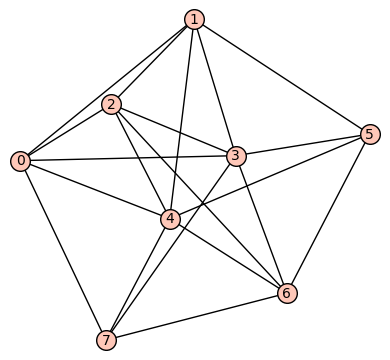

In [71]:
G=Graph('G~xX{s')
G.show()

In [74]:
print Zplus(G)
print find_Z(G)

5
5


In [77]:
print C23T

[ 1  2  1  1  2  0  2  0]
[ 0  1  0  1  1  1 -4  0]
[ 2  0  0  1  3  0  1  1]


In [75]:
var('m00,m01,m02,m10,m11,m12,m20,m21,m22,m30,m31,m32,m40,m41,m42,m50,m51,m52,m60,m61,m62,m70,m71,m72')


M=Matrix([[m00,m01,m02],
         [m10,m11,m12],
         [m20,m21,m22],
         [m30,m31,m32],
         [m40,m41,m42],
         [m50,m51,m52],
         [m60,m61,m62],
         [m70,m71,m72]])
D=Matrix([[1,0,0],
         [0,1,0],
         [0,0,1]])

MT=M.transpose()

A=M*D*MT

In [76]:
for i in range(7):
    N=G.neighbors(i)
    for j in range(i+1,8):
        Aij=A[i][j]
        if j in N:
            print i,j,':','0 != ',expand(Aij)
        else:
            print i,j,':','0 = ', expand(Aij)

0 1 : 0 !=  m00*m10 + m01*m11 + m02*m12
0 2 : 0 !=  m00*m20 + m01*m21 + m02*m22
0 3 : 0 !=  m00*m30 + m01*m31 + m02*m32
0 4 : 0 !=  m00*m40 + m01*m41 + m02*m42
0 5 : 0 =  m00*m50 + m01*m51 + m02*m52
0 6 : 0 =  m00*m60 + m01*m61 + m02*m62
0 7 : 0 !=  m00*m70 + m01*m71 + m02*m72
1 2 : 0 !=  m10*m20 + m11*m21 + m12*m22
1 3 : 0 !=  m10*m30 + m11*m31 + m12*m32
1 4 : 0 !=  m10*m40 + m11*m41 + m12*m42
1 5 : 0 !=  m10*m50 + m11*m51 + m12*m52
1 6 : 0 =  m10*m60 + m11*m61 + m12*m62
1 7 : 0 =  m10*m70 + m11*m71 + m12*m72
2 3 : 0 !=  m20*m30 + m21*m31 + m22*m32
2 4 : 0 !=  m20*m40 + m21*m41 + m22*m42
2 5 : 0 =  m20*m50 + m21*m51 + m22*m52
2 6 : 0 !=  m20*m60 + m21*m61 + m22*m62
2 7 : 0 =  m20*m70 + m21*m71 + m22*m72
3 4 : 0 =  m30*m40 + m31*m41 + m32*m42
3 5 : 0 !=  m30*m50 + m31*m51 + m32*m52
3 6 : 0 !=  m30*m60 + m31*m61 + m32*m62
3 7 : 0 !=  m30*m70 + m31*m71 + m32*m72
4 5 : 0 !=  m40*m50 + m41*m51 + m42*m52
4 6 : 0 !=  m40*m60 + m41*m61 + m42*m62
4 7 : 0 !=  m40*m70 + m41*m71 + m42*m72
5 6 : 0

In [64]:
C23=Matrix([[1,0,2],
         [2,1,0],
         [1,0,0],
         [1,1,1],
         [2,1,3],
         [0,1,0],
         [2,-4,1],
         [0,0,1]])
D=Matrix([[1,0,0],
         [0,1,0],
         [0,0,-1]])

C23T=C23.transpose()

A=C23*D*C23T
A

[-3  2  1 -1 -4  0  0 -2]
[ 2  5  2  3  5  1  0  0]
[ 1  2  1  1  2  0  2  0]
[-1  3  1  1  0  1 -3 -1]
[-4  5  2  0 -4  1 -3 -3]
[ 0  1  0  1  1  1 -4  0]
[ 0  0  2 -3 -3 -4 19 -1]
[-2  0  0 -1 -3  0 -1 -1]

In [54]:
var('a1,a2,a3,a4,a5,a6,a7,a8')
var('b1,b2,b3,b4,b5,b6,b7,b8')

a1=1
a2=1/2
a3=5
a4=2
a5=1/5
a6=3
a7=7
a8=-2

b1=1
b2=1/2
b3=5
b4=2
b5=3
b6=1/4
b7=-1/2
b8=1


H=diagonal_matrix([b1,b2,b3,b4,b5,b6,b7,b8])
G=diagonal_matrix([a1,a2,a3,a4,a5,a6,a7,a8])
G

[  1   0   0   0   0   0   0   0]
[  0 1/2   0   0   0   0   0   0]
[  0   0   5   0   0   0   0   0]
[  0   0   0   2   0   0   0   0]
[  0   0   0   0 1/5   0   0   0]
[  0   0   0   0   0   3   0   0]
[  0   0   0   0   0   0   7   0]
[  0   0   0   0   0   0   0  -2]

In [67]:
C231=G*C23
C232=H*C23
C232T=C232.transpose()

A=C231*D*C232T
A

[    -3      1      5     -2    -12      0      0     -2]
[     1    5/4      5      3   15/2    1/8      0      0]
[     5      5     25     10     30      0     -5      0]
[    -2      3     10      4      0    1/2      3     -2]
[  -4/5    1/2      2      0  -12/5   1/20   3/10   -3/5]
[     0    3/2      0      6      9    3/4      6      0]
[     0      0     70    -42    -63     -7 -133/2     -7]
[     4      0      0      4     18      0     -1      2]

In [68]:
MA=Matroid(A)
MC=Matroid(C23T)
print sorted([sorted(c) for c in MA.circuits()])
print 
print sorted([sorted(c) for c in MC.circuits()])

[[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 6], [0, 1, 3, 5], [0, 1, 3, 6], [0, 1, 3, 7], [0, 1, 4, 5], [0, 1, 4, 6], [0, 1, 5, 6], [0, 1, 5, 7], [0, 1, 6, 7], [0, 2, 3, 5], [0, 2, 3, 6], [0, 2, 4, 5], [0, 2, 4, 6], [0, 2, 5, 6], [0, 2, 7], [0, 3, 4], [0, 3, 5, 6], [0, 3, 5, 7], [0, 3, 6, 7], [0, 4, 5, 6], [0, 4, 5, 7], [0, 4, 6, 7], [0, 5, 6, 7], [1, 2, 3, 4], [1, 2, 3, 6], [1, 2, 3, 7], [1, 2, 4, 6], [1, 2, 5], [1, 2, 6, 7], [1, 3, 4, 5], [1, 3, 4, 6], [1, 3, 5, 6], [1, 3, 5, 7], [1, 3, 6, 7], [1, 4, 5, 6], [1, 4, 7], [1, 5, 6, 7], [2, 3, 4, 5], [2, 3, 4, 6], [2, 3, 4, 7], [2, 3, 5, 6], [2, 3, 5, 7], [2, 3, 6, 7], [2, 4, 5, 6], [2, 4, 5, 7], [2, 4, 6, 7], [2, 5, 6, 7], [3, 4, 5, 6], [3, 4, 5, 7], [3, 4, 6, 7], [3, 5, 6, 7], [4, 5, 6, 7]]

[[0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 2, 6], [0, 1, 3, 5], [0, 1, 3, 6], [0, 1, 3, 7], [0, 1, 4, 5], [0, 1, 4, 6], [0, 1, 5, 6], [0, 1, 5, 7], [0, 1, 6, 7], [0, 2, 3, 5], [0, 2, 3, 6], [0, 2, 4, 5], [0, 2, 4, 6], [0, 2, 5, 6], [0, 2, 7], [0, 3, 4], [0, 3, 

In [69]:
MA.is_isomorphic(MC)

True

In [43]:
C=Matrix([[1,0,1,2,2],
         [1,1,0,2,1],
         [1,0,0,0,0],
         [1,1,3,3,3],
         [1,2,5,2,4],
         [0,1,0,0,0],
         [1,2,3,1,1],
         [0,0,1,0,0]]).transpose()

In [44]:
C

[1 1 1 1 1 0 1 0]
[0 1 0 1 2 1 2 0]
[1 0 0 3 5 0 3 1]
[2 2 0 3 2 0 1 0]
[2 1 0 3 4 0 1 0]

In [45]:
M=Matroid(C)
print sorted([sorted(c) for c in M.circuits()])

[[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 7], [0, 1, 2, 4, 5, 6], [0, 1, 2, 4, 6, 7], [0, 1, 3, 4, 5, 6], [0, 1, 3, 4, 6, 7], [0, 1, 4, 5, 7], [0, 2, 3, 5, 6], [0, 2, 3, 5, 7], [0, 2, 3, 6, 7], [0, 2, 5, 6, 7], [0, 3, 5, 6, 7], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 7], [1, 2, 3, 4, 6, 7], [1, 2, 4, 5, 6, 7], [1, 3, 4, 5, 6, 7], [2, 3, 5, 6, 7]]


In [53]:
G=Matrix([[1,1,1,2,2],
         [0,1,0,2,1],
         [0,0,5,4,0],
         [0,0,0,3,3],
         [0,0,0,0,4]
           ])
G.determinant()

60

In [54]:
GC=G*C
GC

[10  8  1 17 20  1 10  1]
[ 6  6  0 10 10  1  5  0]
[13  8  0 27 33  0 19  5]
[12  9  0 18 18  0  6  0]
[ 8  4  0 12 16  0  4  0]

In [55]:
MG=Matroid(GC)
print sorted([sorted(c) for c in MG.circuits()])

[[0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 6], [0, 1, 2, 3, 4, 7], [0, 1, 2, 4, 5, 6], [0, 1, 2, 4, 6, 7], [0, 1, 3, 4, 5, 6], [0, 1, 3, 4, 6, 7], [0, 1, 4, 5, 7], [0, 2, 3, 5, 6], [0, 2, 3, 5, 7], [0, 2, 3, 6, 7], [0, 2, 5, 6, 7], [0, 3, 5, 6, 7], [1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 7], [1, 2, 3, 4, 6, 7], [1, 2, 4, 5, 6, 7], [1, 3, 4, 5, 6, 7], [2, 3, 5, 6, 7]]


In [91]:
A=Matrix([
    [0,-1,1,0,0,0,0,0],
    [-1,0,0,1,0,0,0,0],
    [1,0,0,1,0,-2,0,0],
    [0,1,-1,0,0,0,0,0],
    [0,0,0,0,0,1,-1,0],
    [0,0,-2,0,1,0,0,1],
    [0,0,0,0,-1,0,0,1],
    [0,0,0,0,0,1,-1,0]
])
AT=A.transpose()
A

[ 0 -1  1  0  0  0  0  0]
[-1  0  0  1  0  0  0  0]
[ 1  0  0  1  0 -2  0  0]
[ 0  1 -1  0  0  0  0  0]
[ 0  0  0  0  0  1 -1  0]
[ 0  0 -2  0  1  0  0  1]
[ 0  0  0  0 -1  0  0  1]
[ 0  0  0  0  0  1 -1  0]

In [117]:
J=A.jordan_form(CyclotomicField(24))
for i in range(8):
    print J[i]

(zeta24^5 - zeta24^3 - zeta24, 0, 0, 0, 0, 0, 0, 0)
(0, -zeta24^5 + zeta24^3 + zeta24, 0, 0, 0, 0, 0, 0)
(0, 0, 2*zeta24^7 - zeta24^5 - zeta24^3 - zeta24, 0, 0, 0, 0, 0)
(0, 0, 0, -2*zeta24^7 + zeta24^5 + zeta24^3 + zeta24, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 1, 0, 0)
(0, 0, 0, 0, 0, 0, 1, 0)
(0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0)


In [2]:
MA=Matroid(A)
MAT=Matroid(AT)

In [46]:
p(x)=A.charpoly(x)
m(x)=A.minpoly(x)
print AT.charpoly(x)

x^8 - 8*x^6 + 12*x^4


In [49]:
m(x).factor()

(x^2 - 2)*(x^2 - 6)*x^3

In [45]:
A^7-8*A^5+12*A^3

[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0]

In [19]:
A.eigenvectors_right()

[(0, [
  (1, 0, 0, 1, 0, 1, 1, 0),
  (0, 1, 1, 0, 1, 0, 0, 1)
  ], 4),
 (-2.449489742783178?,
  [(1, 0.8164965809277260?, -1.632993161855452?, -1, 0.8164965809277260?, -2, 0, 0.8164965809277260?)],
  1),
 (2.449489742783178?,
  [(1, -0.8164965809277260?, 1.632993161855452?, -1, -0.8164965809277260?, -2, 0, -0.8164965809277260?)],
  1),
 (-1.414213562373095?, [(1, 1.414213562373095?, 0, -1, 0, 0, 0, 0)], 1),
 (1.414213562373095?, [(1, -1.414213562373095?, 0, -1, 0, 0, 0, 0)], 1)]

In [5]:
AT.eigenvectors_right()

[(0, [
  (1, 0, 0, 1, 0, 0, 0, 0),
  (0, 0, 0, 0, 1, 0, 0, -1)
  ], 4),
 (-2.449489742783178?,
  [(1, 0, -2.449489742783178?, 1, 1.632993161855452?, -3, 1, 0.8164965809277260?)],
  1),
 (2.449489742783178?,
  [(1, 0, 2.449489742783178?, 1, -1.632993161855452?, -3, 1, -0.8164965809277260?)],
  1),
 (-1.414213562373095?,
  [(1, 1.414213562373095?, 0, -1, -1.414213562373095?, 1, -1, 0)],
  1),
 (1.414213562373095?,
  [(1, -1.414213562373095?, 0, -1, 1.414213562373095?, 1, -1, 0)],
  1)]

In [50]:
Acu=A*A*A
Acu

[  0  -2   6   0  -2   0   0  -2]
[ -4   0   0   0   0   4   0   0]
[  4   0   0   4   0 -12   4   0]
[  0   2  -6   0   2   0   0   2]
[ -2   0   0  -2   0   6  -2   0]
[  0   0 -12   0   8   0   0   4]
[  0   0   0   0   0   0   0   0]
[ -2   0   0  -2   0   6  -2   0]

In [51]:
Acu.eigenvectors_right()

[(0, [
  (1, 0, 0, 0, 0, 1, 2, 0),
  (0, 1, 0, 0, 1, 0, 0, -2),
  (0, 0, 1, 0, 0, 0, 0, 3),
  (0, 0, 0, 1, 0, 0, -1, 0)
  ], 4),
 (-14.69693845669907?,
  [(1, 0.8164965809277260?, -1.632993161855452?, -1, 0.8164965809277260?, -2, 0, 0.8164965809277260?)],
  1),
 (14.69693845669907?,
  [(1, -0.8164965809277260?, 1.632993161855452?, -1, -0.8164965809277260?, -2, 0, -0.8164965809277260?)],
  1),
 (-2.828427124746190?, [(1, 1.414213562373095?, 0, -1, 0, 0, 0, 0)], 1),
 (2.828427124746190?, [(1, -1.414213562373095?, 0, -1, 0, 0, 0, 0)], 1)]

In [6]:
ATsq=AT*AT

In [7]:
ATsq.eigenvectors_right()

[(6, [
  (1, 0, 0, 1, 0, -3, 1, 0),
  (0, 0, 1, 0, -2/3, 0, 0, -1/3)
  ], 2), (2, [
  (1, 0, 0, -1, 0, 1, -1, 0),
  (0, 1, 0, 0, -1, 0, 0, 0)
  ], 2), (0, [
  (1, 0, 0, 1, 0, 0, 0, 0),
  (0, 0, 0, 0, 1, 0, 0, -1),
  (0, 0, 0, 0, 0, 0, 1, 0)
  ], 4)]

In [12]:
print 'circuits for A = ',sorted([sorted(c) for c in MA.circuits()])
print 'circuits for A^T =',sorted([sorted(c) for c in MAT.circuits()])




circuits for A =  [[0, 3, 5, 6], [1, 2, 4, 7]]
circuits for A^T = [[0, 3], [4, 7]]


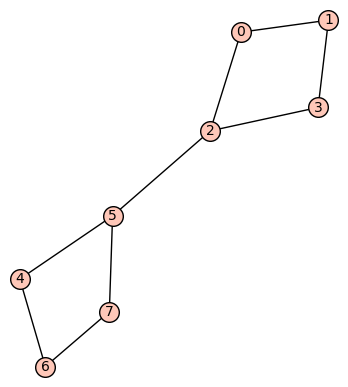

In [13]:
#graph of matrix A
n=8
H=Graph([])
H.add_vertices(range(n))
for i in range(0,n):
    for j in range(i+1,n):
        if A[i][j] != 0:
            H.add_edge((i,j))

H.show()
#G.show()
#H.is_isomorphic(G)

In [78]:
B1=Matrix([
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
print B1
print
var('c1,c2,c3,c4,c5,c6')
B2=Matrix([
    [0,0,0,1,1,1,3,3,3],
    [0,0,0,1,1,1,3,3,3],
    [0,0,0,1,1,1,3,3,3],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
print B2

[ 0  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]

[0 0 0 1 1 1 3 3 3]
[0 0 0 1 1 1 3 3 3]
[0 0 0 1 1 1 3 3 3]
[1 1 1 0 0 0 2 2 2]
[1 1 1 0 0 0 2 2 2]
[1 1 1 0 0 0 2 2 2]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]


In [87]:
J=B1.jordan_form(CyclotomicField(7))

In [90]:
for i in range(8):
    print J[i]

(-3, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 3*zeta7^4 + 3*zeta7^2 + 3*zeta7 + 3, 0, 0, 0, 0, 0, 0, 0)
(0, 0, -3*zeta7^4 - 3*zeta7^2 - 3*zeta7, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0)
(0, 0, 0, 0, 0, 0, 0, 0, 0)


In [39]:
B2.determinant()

0

In [40]:
print B2.eigenvectors_right()
print 
print B1.eigenvectors_right()

[(-3, [
(1, 1, 1, -1, -1, -1, 0, 0, 0)
], 1), (0, [
(1, 0, -1, 0, 0, 0, 0, 0, 0),
(0, 1, -1, 0, 0, 0, 0, 0, 0),
(0, 0, 0, 1, 0, -1, 0, 0, 0),
(0, 0, 0, 0, 1, -1, 0, 0, 0),
(0, 0, 0, 0, 0, 0, 1, 0, -1),
(0, 0, 0, 0, 0, 0, 0, 1, -1)
], 6), (-5.373863542433760?, [(1, 1, 1, 0.1726731646460115?, 0.1726731646460115?, 0.1726731646460115?, -0.6546536707079771?, -0.6546536707079771?, -0.6546536707079771?)], 1), (8.37386354243376?, [(1, 1, 1, 0.8273268353539886?, 0.8273268353539886?, 0.8273268353539886?, 0.6546536707079771?, 0.6546536707079771?, 0.6546536707079771?)], 1)]

[(-3, [
(1, 1, 1, -1, -1, -1, 0, 0, 0)
], 1), (0, [
(1, 0, -1, 0, 0, 0, 0, 0, 0),
(0, 1, -1, 0, 0, 0, 0, 0, 0),
(0, 0, 0, 1, 0, -1, 0, 0, 0),
(0, 0, 0, 0, 1, -1, 0, 0, 0),
(0, 0, 0, 0, 0, 0, 1, 0, -1),
(0, 0, 0, 0, 0, 0, 0, 1, -1)
], 6), (1.500000000000000? - 3.968626966596886?*I, [(1, 1, 1, 1, 1, 1, 0.500000000000000? + 1.322875655532296?*I, 0.500000000000000? + 1.322875655532296?*I, 0.500000000000000? + 1.322875655532296?*I)

In [5]:
MB=Matroid(B)
print sorted([sorted(c) for c in MB.circuits()])

[[0, 1], [0, 2], [0, 3, 6], [0, 3, 7], [0, 3, 8], [0, 4, 6], [0, 4, 7], [0, 4, 8], [0, 5, 6], [0, 5, 7], [0, 5, 8], [1, 2], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 5, 6], [1, 5, 7], [1, 5, 8], [2, 3, 6], [2, 3, 7], [2, 3, 8], [2, 4, 6], [2, 4, 7], [2, 4, 8], [2, 5, 6], [2, 5, 7], [2, 5, 8], [3, 4], [3, 5], [4, 5], [6, 7], [6, 8], [7, 8]]


In [6]:
BT=B.transpose()

In [7]:
MBT=Matroid(BT)
print sorted([sorted(c) for c in MBT.circuits()])

[[0, 1], [0, 2], [0, 3, 6], [0, 3, 7], [0, 3, 8], [0, 4, 6], [0, 4, 7], [0, 4, 8], [0, 5, 6], [0, 5, 7], [0, 5, 8], [1, 2], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 5, 6], [1, 5, 7], [1, 5, 8], [2, 3, 6], [2, 3, 7], [2, 3, 8], [2, 4, 6], [2, 4, 7], [2, 4, 8], [2, 5, 6], [2, 5, 7], [2, 5, 8], [3, 4], [3, 5], [4, 5], [6, 7], [6, 8], [7, 8]]


In [10]:
B.eigenvectors_right()

[(3, [
  (0, 0, 0, 1, 1, 1, 1, 1, 1)
  ], 1), (-3, [
  (1, 1, 1, -1, -1, -1, 0, 0, 0)
  ], 1), (0, [
  (1, 0, 0, 0, 0, -1, 0, 0, -1),
  (0, 1, 0, 0, 0, -1, 0, 0, -1),
  (0, 0, 1, 0, 0, -1, 0, 0, -1),
  (0, 0, 0, 1, 0, -1, 0, 0, 0),
  (0, 0, 0, 0, 1, -1, 0, 0, 0),
  (0, 0, 0, 0, 0, 0, 1, 0, -1),
  (0, 0, 0, 0, 0, 0, 0, 1, -1)
  ], 7)]

In [14]:
C1=Matrix([
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])

C2=Matrix([
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,0,0,0,2,2,2],
    [1,1,1,2,2,2,0,0,0],
    [1,1,1,2,2,2,0,0,0],
    [1,1,1,2,2,2,0,0,0],
])
C1

[0 0 0 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]

In [15]:
print C1.eigenvectors_right()
print
print C2.eigenvectors_right()

[(6, [
(1, 1, 1, 1, 1, 1, 1, 1, 1)
], 1), (-3, [
(1, 1, 1, 0, 0, 0, -1, -1, -1),
(0, 0, 0, 1, 1, 1, -1, -1, -1)
], 2), (0, [
(1, 0, -1, 0, 0, 0, 0, 0, 0),
(0, 1, -1, 0, 0, 0, 0, 0, 0),
(0, 0, 0, 1, 0, -1, 0, 0, 0),
(0, 0, 0, 0, 1, -1, 0, 0, 0),
(0, 0, 0, 0, 0, 0, 1, 0, -1),
(0, 0, 0, 0, 0, 0, 0, 1, -1)
], 6)]

[(-6, [
(0, 0, 0, 1, 1, 1, -1, -1, -1)
], 1), (0, [
(1, 0, -1, 0, 0, 0, 0, 0, 0),
(0, 1, -1, 0, 0, 0, 0, 0, 0),
(0, 0, 0, 1, 0, -1, 0, 0, 0),
(0, 0, 0, 0, 1, -1, 0, 0, 0),
(0, 0, 0, 0, 0, 0, 1, 0, -1),
(0, 0, 0, 0, 0, 0, 0, 1, -1)
], 6), (-2.196152422706632?, [(1, 1, 1, -0.3660254037844386?, -0.3660254037844386?, -0.3660254037844386?, -0.3660254037844386?, -0.3660254037844386?, -0.3660254037844386?)], 1), (8.19615242270664?, [(1, 1, 1, 1.366025403784439?, 1.366025403784439?, 1.366025403784439?, 1.366025403784439?, 1.366025403784439?, 1.366025403784439?)], 1)]


In [19]:
D=matrix([
    [1,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
D

[ 1  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 1  1  1  0  0  0  1  1  1]
[ 1  1  1  0  0  0  1  1  1]
[ 1  1  1  0  0  0  1  1  1]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]

In [21]:
import sympy as sp  

In [28]:
#D.eigenvectors_right()
D=sp.Matrix([
    [1,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
# D=Matrix([
#     [1,0,0,1,1,1,-1,-1,-1],
#     [0,0,0,1,1,1,-1,-1,-1],
#     [0,0,0,1,1,1,-1,-1,-1],
#     [1,1,1,0,0,0,1,1,1],
#     [1,1,1,0,0,0,1,1,1],
#     [1,1,1,0,0,0,1,1,1],
#     [1,1,1,1,1,1,0,0,0],
#     [1,1,1,1,1,1,0,0,0],
#     [1,1,1,1,1,1,0,0,0],
# ])
D

Matrix([
[1, 0, 0, 1, 1, 1, -1, -1, -1],
[0, 0, 0, 1, 1, 1, -1, -1, -1],
[0, 0, 0, 1, 1, 1, -1, -1, -1],
[1, 1, 1, 0, 0, 0,  1,  1,  1],
[1, 1, 1, 0, 0, 0,  1,  1,  1],
[1, 1, 1, 0, 0, 0,  1,  1,  1],
[1, 1, 1, 1, 1, 1,  0,  0,  0],
[1, 1, 1, 1, 1, 1,  0,  0,  0],
[1, 1, 1, 1, 1, 1,  0,  0,  0]])

In [29]:
D.diagonalize()

(Matrix([
 [ 18,  0,  0,  0,  0,  0,  0, -2, 0],
 [ 24, -1,  0,  0, -1, -1, -1,  0, 0],
 [ 24,  1,  0,  0,  0,  0,  0,  0, 0],
 [-23,  0, -1, -1,  1,  1,  1,  1, 1],
 [-23,  0,  1,  0,  0,  0,  0,  1, 1],
 [-23,  0,  0,  1,  0,  0,  0,  1, 1],
 [  1,  0,  0,  0,  1,  0,  0,  1, 1],
 [  1,  0,  0,  0,  0,  1,  0,  1, 1],
 [  1,  0,  0,  0,  0,  0,  1,  1, 1]]), Matrix([
 [-3, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [ 0, 0, 0, 0, 0, 0, 0, 0, 3]]))

In [5]:
F=Matrix([
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [0,0,0,1,1,1,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,0,0,0,-1,-1,-1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
F

[ 0  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 0  0  0  1  1  1 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  0  0  0 -1 -1 -1]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]
[ 1  1  1  1  1  1  0  0  0]

In [6]:
F.eigenvectors_right()

[(-3, [
  (1, 1, 1, -1, -1, -1, 0, 0, 0)
  ], 1), (0, [
  (1, 0, -1, 0, 0, 0, 0, 0, 0),
  (0, 1, -1, 0, 0, 0, 0, 0, 0),
  (0, 0, 0, 1, 0, -1, 0, 0, 0),
  (0, 0, 0, 0, 1, -1, 0, 0, 0),
  (0, 0, 0, 0, 0, 0, 1, 0, -1),
  (0, 0, 0, 0, 0, 0, 0, 1, -1)
  ], 6), (1.500000000000000? - 3.968626966596886?*I,
  [(1, 1, 1, 1, 1, 1, 0.500000000000000? + 1.322875655532296?*I, 0.500000000000000? + 1.322875655532296?*I, 0.500000000000000? + 1.322875655532296?*I)],
  1), (1.500000000000000? + 3.968626966596886?*I,
  [(1, 1, 1, 1, 1, 1, 0.500000000000000? - 1.322875655532296?*I, 0.500000000000000? - 1.322875655532296?*I, 0.500000000000000? - 1.322875655532296?*I)],
  1)]

In [8]:
F1=Matrix([
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [0,0,0,1,1,1,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,0,0,0,1,1,1],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
    [1,1,1,1,1,1,0,0,0],
])
F1

[0 0 0 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 0 0 0 1 1 1]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]
[1 1 1 1 1 1 0 0 0]

In [9]:
F2=Matrix([
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,-2,-2,-2],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0],
])
F2

[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0 -2 -2 -2]
[ 0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0]

In [11]:
print F1*F2
print F2*F1

[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0  -6  -6  -6]
[  0   0   0   0   0   0 -12 -12 -12]
[  0   0   0   0   0   0 -12 -12 -12]
[  0   0   0   0   0   0 -12 -12 -12]
[-6 -6 -6 -6 -6 -6  0  0  0]
[-6 -6 -6 -6 -6 -6  0  0  0]
[-6 -6 -6 -6 -6 -6  0  0  0]
[-6 -6 -6 -6 -6 -6  0  0  0]
[-6 -6 -6 -6 -6 -6  0  0  0]
[-6 -6 -6 -6 -6 -6  0  0  0]
[ 0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0]


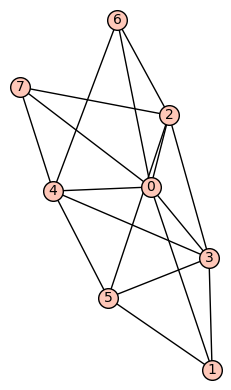

In [11]:
G=Graph('Gvd|TO')
G.show()

In [34]:
M1=matrix([[3,1,5],
         [1,1,1],
         [0,1,1],
         [2,1,2],
         [0,1,1],
         [1,2,1],
         [1,0,1],
         [1,0,1]])

W1=matrix([[6,2,10],
         [1,1,1],
         [0,1,1],
         [2,1,2],
         [0,3,3],
         [1,2,1],
         [4,0,4],
         [1,0,1]])

D=matrix([[1,0,0],
         [0,1,0],
         [0,0,-1]])

M1T=M1.transpose()
W1T=W1.transpose()
A1=M1*D*M1T
B1=W1*D*M1T

In [32]:
print A1
print A1.rank()
print
print B1
print B1.rank()

[-15  -1  -4  -3  -4   0  -2  -2]
[ -1   1   0   1   0   2   0   0]
[ -4   0   0  -1   0   1  -1  -1]
[ -3   1  -1   1  -1   2   0   0]
[ -4   0   0  -1   0   1  -1  -1]
[  0   2   1   2   1   4   0   0]
[ -2   0  -1   0  -1   0   0   0]
[ -2   0  -1   0  -1   0   0   0]
3

[-30  -2  -8  -6  -8   0  -4  -4]
[ -1   1   0   1   0   2   0   0]
[ -4   0   0  -1   0   1  -1  -1]
[ -3   1  -1   1  -1   2   0   0]
[-12   0   0  -3   0   3  -3  -3]
[  0   2   1   2   1   4   0   0]
[ -8   0  -4   0  -4   0   0   0]
[ -2   0  -1   0  -1   0   0   0]
3


In [40]:
B1T=B1.transpose()

print A1.rref()
print 
print A1.transpose().rref()
print
print B1.rref()
print 
print B1T.rref()
        
    

[   1    0    0  1/4    0 -1/4  1/4  1/4]
[   0    1    0  5/4    0  7/4  1/4  1/4]
[   0    0    1 -1/2    1  1/2 -1/2 -1/2]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]

[   1    0    0  1/4    0 -1/4  1/4  1/4]
[   0    1    0  5/4    0  7/4  1/4  1/4]
[   0    0    1 -1/2    1  1/2 -1/2 -1/2]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]

[   1    0    0  1/4    0 -1/4  1/4  1/4]
[   0    1    0  5/4    0  7/4  1/4  1/4]
[   0    0    1 -1/2    1  1/2 -1/2 -1/2]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0    0    0]
[   0    0    0    0    0    0  

In [41]:
MA=Matroid(A1)
MB=Matroid(B1)
MBT=Matroid(B1T)

In [42]:
print sorted([sorted(c) for c in MA.circuits()])
print 
print sorted([sorted(c) for c in MB.circuits()])
print 
print sorted([sorted(c) for c in MBT.circuits()])

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 2, 6], [0, 1, 2, 7], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 4, 6], [0, 1, 4, 7], [0, 2, 3, 5], [0, 2, 3, 6], [0, 2, 3, 7], [0, 2, 5, 6], [0, 2, 5, 7], [0, 3, 4, 5], [0, 3, 4, 6], [0, 3, 4, 7], [0, 4, 5, 6], [0, 4, 5, 7], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 5, 6], [1, 5, 7], [2, 4], [3, 5, 6], [3, 5, 7], [6, 7]]

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 2, 6], [0, 1, 2, 7], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 4, 6], [0, 1, 4, 7], [0, 2, 3, 5], [0, 2, 3, 6], [0, 2, 3, 7], [0, 2, 5, 6], [0, 2, 5, 7], [0, 3, 4, 5], [0, 3, 4, 6], [0, 3, 4, 7], [0, 4, 5, 6], [0, 4, 5, 7], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 5, 6], [1, 5, 7], [2, 4], [3, 5, 6], [3, 5, 7], [6, 7]]

[[0, 1, 2, 3], [0, 1, 2, 5], [0, 1, 2, 6], [0, 1, 2, 7], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 4, 6], [0, 1, 4, 7], [0, 2, 3, 5], [0, 2, 3, 6], [0, 2, 3, 7], [0, 2, 5, 6], [0, 2, 5, 7], [0, 3, 4, 5], [0, 3, 4, 6], [0, 3, 4, 7], [0, 4, 5, 6], [0, 4, 5, 7], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 5, 6], [1, 5, 7]

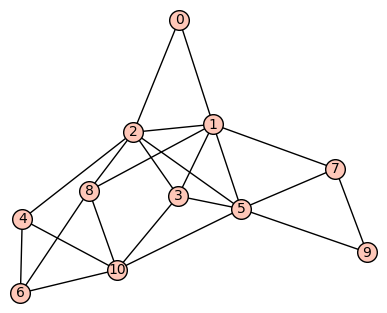

In [67]:
#larger graph with forts that have small numbering 
#leave the larger numbered vertices out of the fort
#two forts with at least 4 vertices each
#try keeping the nullity of the matrix low

G=Graph({0:[1,2],1:[2,3,5,7,8],2:[4,8,5],3:[5,2,10],4:[6,10],5:[7,9,10],6:[8,10],7:[9],8:[10]})
G.show()

In [68]:
A=All_Forts(G)

In [69]:
for a in A:
    if 0 in a:
        print a

[0, 4, 8]
[0, 4, 6, 8]
[0, 2, 4, 10]
[0, 2, 3, 6]
[0, 3, 5, 9]
[0, 3, 6, 10]
[0, 2, 8, 10]
[0, 3, 5, 7]
[0, 2, 6, 10]
[0, 2, 6, 8, 10]
[0, 2, 4, 6, 10]
[0, 2, 3, 4, 6]
[0, 1, 6, 9, 10]
[0, 2, 3, 4, 8]
[0, 3, 4, 6, 10]
[0, 3, 5, 7, 9]
[0, 2, 4, 8, 10]
[0, 2, 3, 4, 10]
[0, 3, 4, 8, 10]
[0, 4, 7, 8, 9]
[0, 2, 5, 6, 9]
[0, 5, 6, 7, 10]
[0, 2, 3, 8, 10]
[0, 3, 6, 8, 10]
[0, 5, 6, 9, 10]
[0, 2, 5, 6, 7]
[0, 2, 3, 6, 8]
[0, 1, 4, 9, 10]
[0, 2, 3, 6, 10]
[0, 1, 2, 6, 8, 9]
[0, 4, 5, 8, 9, 10]
[0, 5, 6, 7, 8, 10]
[0, 1, 2, 5, 6, 9]
[0, 3, 4, 5, 7, 8]
[0, 4, 5, 6, 7, 10]
[0, 1, 4, 5, 6, 7]
[0, 1, 4, 5, 7, 10]
[0, 2, 3, 4, 6, 8]
[0, 2, 4, 5, 7, 8]
[0, 2, 5, 6, 8, 9]
[0, 1, 6, 7, 9, 10]
[0, 3, 4, 5, 8, 9]
[0, 4, 6, 7, 8, 9]
[0, 1, 2, 3, 6, 9]
[0, 4, 5, 7, 8, 10]
[0, 4, 5, 6, 9, 10]
[0, 1, 2, 8, 9, 10]
[0, 1, 3, 4, 9, 10]
[0, 1, 4, 7, 9, 10]
[0, 2, 3, 6, 7, 9]
[0, 1, 4, 5, 6, 9]
[0, 3, 5, 6, 9, 10]
[0, 2, 5, 6, 9, 10]
[0, 2, 4, 5, 9, 10]
[0, 1, 2, 4, 9, 10]
[0, 1, 4, 8, 9, 10]
[0, 2, 4, 5, 6, 9]
[0

In [70]:
#{0,2,4,10},{0,3,5,9}
B=Matrix([
    [1,0,0,0,0,0,0,0,0,1,1],
    [0,1,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,2],
    [0,0,0,1,0,0,0,0,0,3,0],
    [0,0,0,0,1,0,0,0,0,0,4],
    [0,0,0,0,0,1,0,0,0,5,0],
    [0,0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,1,0,0]
])

B

[1 0 0 0 0 0 0 0 0 1 1]
[0 1 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 2]
[0 0 0 1 0 0 0 0 0 3 0]
[0 0 0 0 1 0 0 0 0 0 4]
[0 0 0 0 0 1 0 0 0 5 0]
[0 0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0]

In [71]:
M=Matroid(B)
C=sorted([sorted(c) for c in M.circuits()])

In [72]:
print C

[[0, 2, 4, 10], [0, 3, 5, 9], [2, 3, 4, 5, 9, 10]]


In [78]:
Bstar=Matrix([
    [-1,0,0,-3,0,-5,0,0,0,1,0],
    [-1,0,-2,0,-4,0,0,0,0,0,1]
])
BstarT=Bstar.transpose()
Bstar

[-1  0  0 -3  0 -5  0  0  0  1  0]
[-1  0 -2  0 -4  0  0  0  0  0  1]

[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]

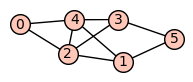

In [45]:
G=Graph({0:[4,5],1:[2,5],2:[3,4,5],3:[4],4:[5]})
G.relabel({2:3,3:2})
G.add_edge(1,4)
G.relabel({2:3,3:2})
G.delete_vertex(5)
G.add_edge(0,2)
G.add_vertex(5)
G.add_edges([(3,5),(1,5)])
G.show(figsize=(2,2))



In [46]:
A=All_Forts(G)

In [47]:
print A

[[1, 3], [2, 4], [0, 2, 4], [0, 2, 5], [1, 3, 5], [0, 4, 5], [0, 1, 3], [2, 4, 5], [0, 1, 3, 5], [1, 2, 3, 4], [0, 1, 2, 5], [0, 2, 4, 5], [2, 3, 4, 5], [1, 2, 4, 5], [0, 3, 4, 5], [0, 2, 3, 5], [0, 1, 2, 3], [0, 1, 4, 5], [0, 1, 3, 4], [0, 1, 2, 3, 5], [1, 2, 3, 4, 5], [0, 1, 3, 4, 5], [0, 1, 2, 4, 5], [0, 1, 2, 3, 4], [0, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]


In [52]:
B=Matrix([
[1,0,0,3,0,5],
[0,1,0,1,0,0],
[0,0,1,0,1,1]
])
print B

[1 0 0 3 0 5]
[0 1 0 1 0 0]
[0 0 1 0 1 1]


In [53]:
M=Matroid(B)
C=sorted([sorted(c) for c in M.circuits()])
C

[[0, 1, 3], [0, 2, 5], [0, 4, 5], [1, 2, 3, 5], [1, 3, 4, 5], [2, 4]]

In [6]:
B=Matrix([[1,0,0,1,3,2],
         [0,1,0,1,1,1],
         [0,0,1,0,0,0]])
print B
M=Matroid(B)
C=sorted([sorted(c) for c in M.circuits()])

[1 0 0 1 3 2]
[0 1 0 1 1 1]
[0 0 1 0 0 0]


In [7]:
C

[[0, 1, 3],
 [0, 1, 4],
 [0, 1, 5],
 [0, 3, 4],
 [0, 3, 5],
 [0, 4, 5],
 [1, 3, 4],
 [1, 3, 5],
 [1, 4, 5],
 [3, 4, 5]]

In [50]:
B.rank()

2

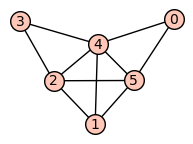

In [11]:
G=Graph({0:[4,5],1:[2,4,5],2:[3,4,5],3:[4],4:[5]})
G.show(figsize=(2,2))

In [10]:
print All_Forts(G)
print C

[[0, 1, 5], [0, 2, 4], [0, 1, 3], [3, 4, 5], [1, 2, 3], [2, 4, 5], [0, 1, 3, 5], [0, 2, 4, 5], [2, 3, 4, 5], [1, 2, 4, 5], [0, 3, 4, 5], [0, 2, 3, 5], [0, 2, 3, 4], [1, 3, 4, 5], [0, 1, 2, 3], [0, 1, 2, 4], [0, 1, 3, 4], [0, 1, 2, 3, 5], [1, 2, 3, 4, 5], [0, 1, 3, 4, 5], [0, 1, 2, 4, 5], [0, 1, 2, 3, 4], [0, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5]]
[[0, 1, 3], [0, 1, 4], [0, 1, 5], [0, 3, 4], [0, 3, 5], [0, 4, 5], [1, 3, 4], [1, 3, 5], [1, 4, 5], [2], [3, 4, 5]]


In [ ]:


G=Graph({1:[2,5,6],2:[3,7],3:[4,8],4:[5,9],5:[10],6:[11],7:[12],8:[13],9:[14],10:[15]})
G.show()

In [15]:
A=All_Forts(G)

In [16]:
len(A)

462

In [23]:
for i in range(len(A)):
    Ai=A[i]
    if 6 in Ai:
        if not(10 in Ai):
            print Ai

[2, 6, 8, 11, 12, 13]
[5, 6, 9, 11, 14, 15]
[2, 6, 7, 8, 11, 12, 13]
[1, 2, 4, 6, 11, 12, 14]
[1, 3, 5, 6, 11, 13, 15]
[1, 3, 4, 6, 11, 13, 14]
[3, 5, 6, 7, 11, 12, 13, 15]
[2, 3, 6, 9, 11, 12, 13, 14]
[4, 5, 6, 8, 11, 13, 14, 15]
[1, 2, 4, 6, 9, 11, 12, 14]
[1, 3, 5, 6, 8, 11, 13, 15]
[1, 3, 4, 6, 8, 11, 13, 14]
[2, 4, 5, 6, 11, 12, 14, 15]
[2, 3, 5, 6, 11, 12, 13, 15]
[1, 3, 4, 6, 9, 11, 13, 14]
[1, 2, 4, 6, 7, 11, 12, 14]
[1, 3, 5, 6, 7, 11, 12, 13, 15]
[1, 3, 4, 6, 7, 11, 12, 13, 14]
[1, 3, 5, 6, 9, 11, 13, 14, 15]
[4, 5, 6, 8, 9, 11, 13, 14, 15]
[1, 2, 4, 5, 6, 11, 12, 14, 15]
[1, 2, 3, 4, 6, 11, 12, 13, 14]
[1, 5, 6, 7, 9, 11, 12, 14, 15]
[1, 2, 4, 6, 8, 11, 12, 13, 14]
[1, 2, 4, 6, 7, 9, 11, 12, 14]
[2, 3, 6, 8, 9, 11, 12, 13, 14]
[3, 5, 6, 7, 8, 11, 12, 13, 15]
[2, 3, 5, 6, 8, 11, 12, 13, 15]
[2, 3, 5, 6, 7, 11, 12, 13, 15]
[2, 3, 6, 7, 9, 11, 12, 13, 14]
[1, 2, 3, 5, 6, 11, 12, 13, 15]
[1, 3, 4, 5, 6, 11, 13, 14, 15]
[2, 4, 5, 6, 7, 11, 12, 14, 15]
[1, 3, 4, 6, 8, 9, 11, 13, 1

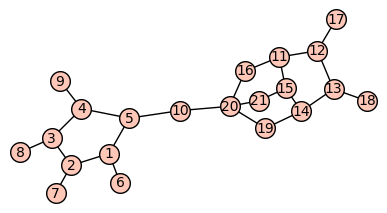

In [27]:
G=Graph({1:[2,5,6],2:[3,7],3:[4,8],4:[5,9],5:[10],10:[20],15:[11,14],11:[12,16],12:[13,17],13:[14,18],14:[19],20:[21,19,16],21:[15]})
G.show()

In [25]:
mr=minrank_bounds(G)
21-mr[0]

4

In [26]:
find_Z(G)

5

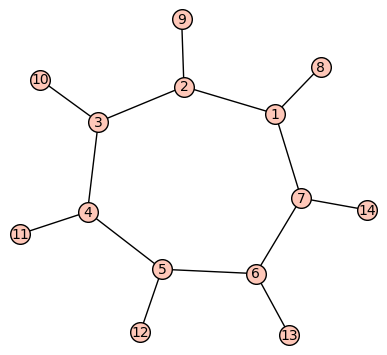

In [8]:
G=Graph({1:[2,7,8],2:[3,9],3:[4,10],4:[5,11],5:[6,12],6:[7,13],7:[14]})
G.show()

In [11]:
mr=minrank_bounds(G)
print 14-mr[0]

3


In [12]:
find_Z(G)

4

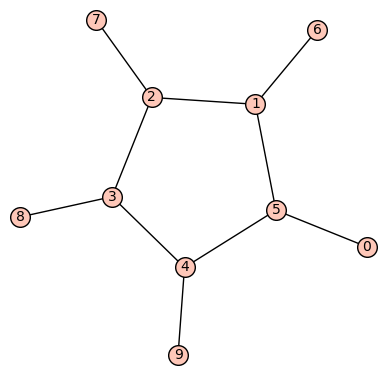

In [13]:
H=Graph({1:[2,5,6],2:[3,7],3:[4,8],4:[5,9],5:[0]})
H.show()

In [14]:
mr=minrank_bounds(H)
print 10-mr[0]

2


In [15]:
find_Z(H)

3

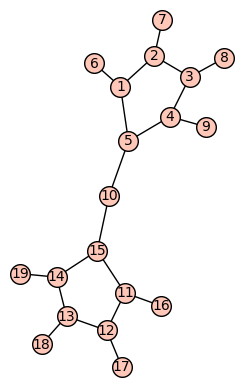

In [7]:
G=Graph({1:[2,5,6],2:[3,7],3:[4,8],4:[5,9],5:[10],10:[15],15:[11,14],11:[12,16],12:[13,17],13:[14,18],14:[19]})
G.show()

In [11]:
minrank_bounds(G)

(16, 16)

In [9]:
A=All_Forts(G)

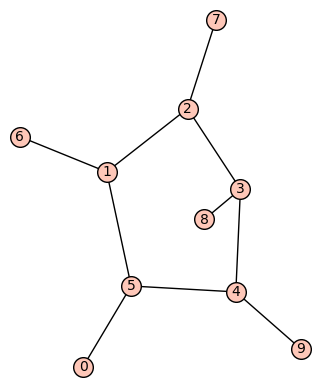

In [17]:
H=Graph({1:[2,5,6],2:[3,7],3:[4,8],4:[5,9],5:[0]})
H.show()

In [14]:
FG=Fort_RGraph(H)

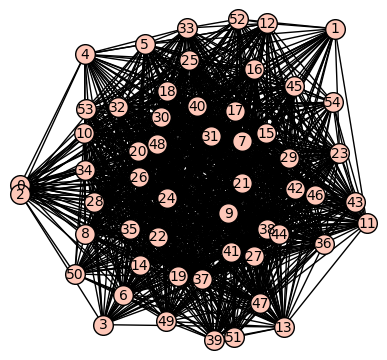

In [15]:
FG.show()

In [18]:
#the set of circuits correspond to the set of minimal forts in a compatible collection


AllBaseSets=[]

k=3
C=CompCollForts(H,k,data_type='string')
for c in C:
    M=Matroid(groundset='1234567890',circuits=c)
    B=sorted([sorted(b) for b in M.bases()])
    Bstr=[]
    for base in B:
        b=''
        for v in base:
            b=b+v
        Bstr.append(b)
        AllBaseSets.append(b)
    print 'rank of matroid: ', M.rank()
    print 'circuits: ', c
    #print 'bases: ', Bstr
    print '========================================================================'


rank of matroid:  8
circuits:  ['134689', '023578', '01245679']
rank of matroid:  8
circuits:  ['124679', '023578', '01345689']
rank of matroid:  8
circuits:  ['024579', '134689', '01235678']
rank of matroid:  8
circuits:  ['013568', '124679', '02345789']
rank of matroid:  8
circuits:  ['013568', '024579', '12346789']
rank of matroid:  8
circuits:  ['0489', '012678', '124679']
rank of matroid:  8
circuits:  ['0569', '236789', '023578']
rank of matroid:  8
circuits:  ['0167', '134689', '034789']
rank of matroid:  8
circuits:  ['0167', '0489', '146789']
rank of matroid:  8
circuits:  ['2678', '045689', '024579']
rank of matroid:  8
circuits:  ['2678', '0489', '024679']
rank of matroid:  8
circuits:  ['2678', '0569', '025789']
rank of matroid:  8
circuits:  ['3789', '013568', '015679']
rank of matroid:  8
circuits:  ['3789', '0569', '035678']
rank of matroid:  8
circuits:  ['3789', '0167', '013689']


In [26]:
F=['136890afg','1670acfhi','3789','cghi','1670afg','136890acfhi']
M=Matroid(groundset='1234567890abcdefghi',circuits=F)
M.is_valid()
M.rank()


16

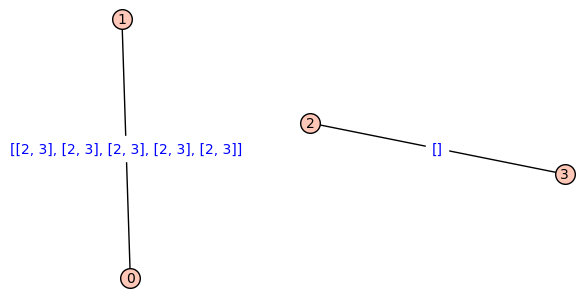

In [21]:
F=[[1,3,6,8,9,10,11,16,17],[1,6,7,10,11,13,16,18,19],[3,7,8,9],[13,17,18,19]]

#construct edges of Fort Graph
F=[Set(f) for f in F]
BP=BadPairs(F)
BP=list(Set(BP))
l=len(F)
E=Subsets(range(l),2)
GP=list(set(E) - set(BP))
GPlist=[sorted(x) for x in GP]

#turn edges into tuples and define Fort Graph
GPtuple=[tuple(a) for a in GPlist]
FortGP=Graph(GPtuple)

#remove edges between a subset and a set containing it
GPlist_min=copy(GPlist)
lenGP=len(GP)
for i in range(lenGP):
    index0=GPlist[i][0]
    index1=GPlist[i][1]
    if (F[index0].issubset(F[index1]) or F[index1].issubset(F[index0])):
        #print index0,A1[index0],index1,A1[index1]
        GPlist_min.remove(GPlist[i])

#refined edge set
GPmin_edges=[tuple(a) for a in GPlist_min]
FortGPmin=Graph(GPmin_edges)

#labels edeges with forts that complete the pair
for x in FortGPmin.edges():
    list_x=list(x)
    FortGPmin.set_edge_label(list_x[0],list_x[1],ExchangeUnionsIndices([F[list_x[0]],F[list_x[1]]],F))

#plot Fort Graph with labeled edges
#FortGPmin.plot(vertex_color='white',vertex_size=500,edge_labels=True).show(figsize=(10,10))
#print 'clique number = ', FortGPmin.clique_number()

FG=FortGPmin
FG.plot(edge_labels='True').show(figsize=(5,5))


In [10]:
print A

[[3, 7, 8, 9], [2, 6, 7, 8], [12, 16, 17, 18], [13, 17, 18, 19], [11, 12, 14, 16, 17, 19], [5, 6, 9, 15, 16, 19], [11, 13, 14, 16, 18, 19], [12, 13, 16, 17, 18, 19], [2, 3, 6, 7, 8, 9], [11, 14, 16, 17, 18, 19], [1, 3, 4, 6, 8, 9], [1, 2, 4, 6, 7, 9], [1, 4, 6, 7, 8, 9], [1, 6, 7, 10, 14, 18, 19], [11, 13, 14, 16, 17, 18, 19], [5, 6, 9, 10, 11, 16, 17], [5, 6, 9, 10, 15, 16, 19], [5, 6, 9, 10, 14, 18, 19], [1, 3, 4, 6, 7, 8, 9], [1, 6, 7, 10, 11, 16, 17], [4, 8, 9, 10, 15, 16, 19], [1, 2, 4, 6, 7, 8, 9], [11, 12, 14, 16, 17, 18, 19], [1, 6, 7, 10, 15, 16, 19], [4, 8, 9, 10, 14, 18, 19], [4, 8, 9, 10, 11, 16, 17], [5, 6, 9, 11, 13, 15, 16, 18], [1, 2, 3, 4, 6, 7, 8, 9], [2, 3, 5, 7, 8, 15, 16, 19], [3, 7, 8, 9, 13, 17, 18, 19], [5, 6, 9, 12, 14, 15, 17, 19], [2, 6, 7, 8, 12, 16, 17, 18], [2, 4, 5, 7, 9, 15, 16, 19], [3, 5, 6, 7, 8, 15, 16, 19], [5, 6, 9, 11, 15, 16, 17, 19], [2, 6, 7, 8, 13, 17, 18, 19], [5, 6, 9, 12, 13, 15, 17, 18], [1, 3, 5, 6, 8, 15, 16, 19], [1, 5, 6, 7, 9, 15, 16,

In [ ]:
#the set of circuits correspond to the set of minimal forts in a compatible collection


AllBaseSets=[]

for k in range(1,m+1):
    C=CompCollForts(G,k,data_type='string')
    for c in C:
        M=Matroid(groundset='0123',circuits=c)
        B=sorted([sorted(b) for b in M.bases()])
        Bstr=[]
        for base in B:
            b=''
            for v in base:
                b=b+v
            Bstr.append(b)
            AllBaseSets.append(b)
        print 'rank of matroid: ', M.rank()
        print 'circuits: ', c
        #print 'bases: ', Bstr
        print '========================================================================'


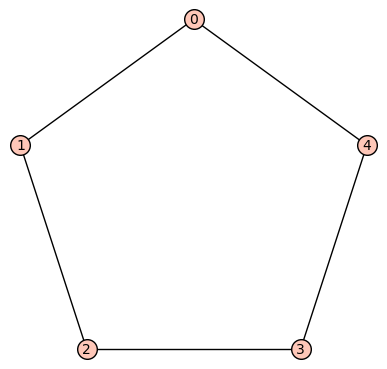

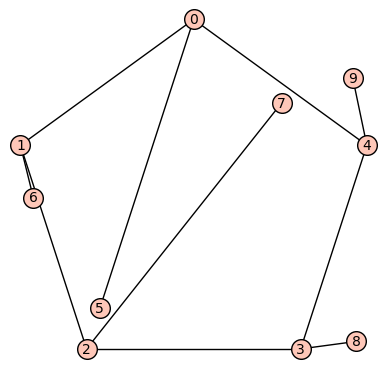

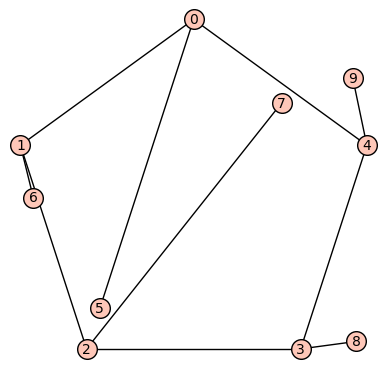

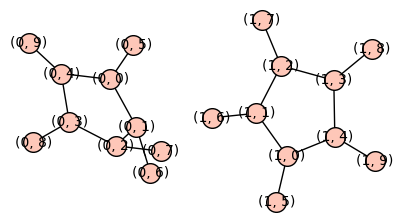

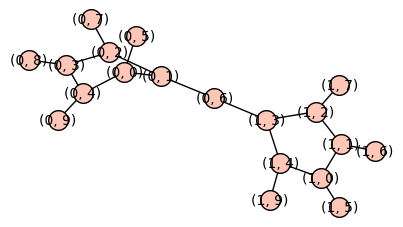

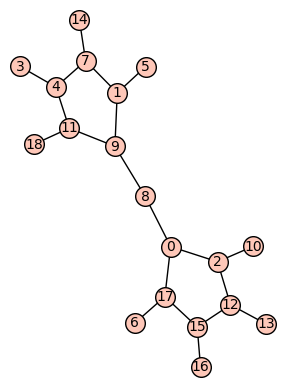

In [10]:
G=graphs.CycleGraph(5)
G.show()
G.add_vertices([5,6,7,8,9])
G.add_edges([(0,5),(1,6),(2,7),(3,8),(4,9)])
G.show()
H=deepcopy(G)
H.show()
H=G.disjoint_union(H)
H.show()
H.merge_vertices([(0,6),(1,8)])
H.show()
H.relabel()
H.show()

In [14]:
A=All_Forts(H)

In [19]:
F=[]
for a in A:
    S=Set([8,0,2,12,15,17,10,13,16,6]).intersection(Set(a))
    if len(S)==0:
        F.append(a)
        print a

[3, 4, 14, 18]
[3, 5, 7, 14]
[1, 3, 4, 5, 11, 18]
[3, 4, 5, 7, 14, 18]
[1, 5, 7, 11, 14, 18]
[1, 3, 5, 11, 14, 18]
[1, 3, 4, 5, 11, 14, 18]
[1, 3, 5, 7, 11, 14, 18]
[1, 3, 4, 5, 7, 11, 14, 18]


In [20]:
F

[[3, 4, 14, 18],
 [3, 5, 7, 14],
 [1, 3, 4, 5, 11, 18],
 [3, 4, 5, 7, 14, 18],
 [1, 5, 7, 11, 14, 18],
 [1, 3, 5, 11, 14, 18],
 [1, 3, 4, 5, 11, 14, 18],
 [1, 3, 5, 7, 11, 14, 18],
 [1, 3, 4, 5, 7, 11, 14, 18]]

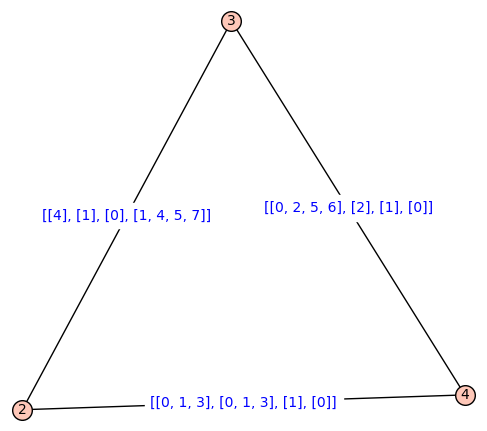

In [38]:

#construct edges of Fort Graph
F=[Set(f) for f in F]
BP=BadPairs(F)
BP=list(Set(BP))
l=len(F)
E=Subsets(range(l),2)
GP=list(set(E) - set(BP))
GPlist=[sorted(x) for x in GP]

#turn edges into tuples and define Fort Graph
GPtuple=[tuple(a) for a in GPlist]
FortGP=Graph(GPtuple)

#remove edges between a subset and a set containing it
GPlist_min=copy(GPlist)
lenGP=len(GP)
for i in range(lenGP):
    index0=GPlist[i][0]
    index1=GPlist[i][1]
    if (F[index0].issubset(F[index1]) or F[index1].issubset(F[index0])):
        #print index0,A1[index0],index1,A1[index1]
        GPlist_min.remove(GPlist[i])

#refined edge set
GPmin_edges=[tuple(a) for a in GPlist_min]
FortGPmin=Graph(GPmin_edges)

#labels edeges with forts that complete the pair
for x in FortGPmin.edges():
    list_x=list(x)
    FortGPmin.set_edge_label(list_x[0],list_x[1],ExchangeUnionsIndices([F[list_x[0]],F[list_x[1]]],F))

#plot Fort Graph with labeled edges
#FortGPmin.plot(vertex_color='white',vertex_size=500,edge_labels=True).show(figsize=(10,10))
#print 'clique number = ', FortGPmin.clique_number()

FG=FortGPmin
FG.subgraph([2,4,3]).plot(edge_labels=True).show(figsize=(5,5))


In [35]:
print A[6]
print A[7]

[1, 3, 4, 5, 11, 18]
[3, 4, 5, 7, 14, 18]


In [29]:
FG.clique_number()

3

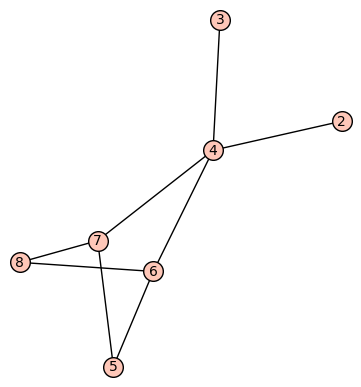

In [7]:
G=Graph({2:[4],3:[4],4:[6,7],5:[6,7],8:[6,7]})
G.show()

In [20]:
AFG=All_Forts(G)
print AFG

[[6, 7], [5, 8], [2, 3], [5, 6, 7], [2, 6, 7], [3, 6, 7], [6, 7, 8], [2, 3, 4, 8], [2, 3, 4, 5], [2, 3, 6, 7], [2, 5, 6, 8], [2, 5, 6, 7], [3, 5, 7, 8], [2, 6, 7, 8], [3, 5, 6, 7], [2, 3, 5, 8], [3, 5, 6, 8], [5, 6, 7, 8], [2, 5, 7, 8], [3, 6, 7, 8], [2, 3, 6, 7, 8], [2, 3, 5, 6, 8], [2, 3, 4, 5, 8], [2, 3, 5, 6, 7], [2, 5, 6, 7, 8], [3, 5, 6, 7, 8], [2, 3, 4, 6, 7], [2, 3, 5, 7, 8], [2, 3, 4, 6, 7, 8], [2, 3, 4, 5, 6, 8], [2, 3, 5, 6, 7, 8], [2, 3, 4, 5, 7, 8], [2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7, 8]]


In [14]:
f0=Set([2,3,5,8])
f1=Set([2,3,4,6,7])

In [25]:
union=f0.union(f1)
inter=f0.intersection(f1)
for x in inter:
    print x
    Lunion=list(union)
    Lunion.remove(x)
    union_minus=Set(Lunion)
    print union_minus
    for i in range(len(AFG)):
        f=AFG[i]
        Sf=Set(f)
        if Sf.issubset(union_minus):
            print i,sorted(Sf)

2
{3, 4, 5, 6, 7, 8}
0 [6, 7]
1 [5, 8]
3 [5, 6, 7]
5 [3, 6, 7]
6 [6, 7, 8]
12 [3, 5, 7, 8]
14 [3, 5, 6, 7]
16 [3, 5, 6, 8]
17 [5, 6, 7, 8]
19 [3, 6, 7, 8]
25 [3, 5, 6, 7, 8]
3
{2, 4, 5, 6, 7, 8}
0 [6, 7]
1 [5, 8]
3 [5, 6, 7]
4 [2, 6, 7]
6 [6, 7, 8]
10 [2, 5, 6, 8]
11 [2, 5, 6, 7]
13 [2, 6, 7, 8]
17 [5, 6, 7, 8]
18 [2, 5, 7, 8]
24 [2, 5, 6, 7, 8]


In [26]:
f0=Set([2,3,5,8])
f1=Set([2,3,4,6,7])
f2=Set([5,6,7,8])

In [27]:
union=f0.union(f2)
inter=f0.intersection(f2)
for x in inter:
    print x
    Lunion=list(union)
    Lunion.remove(x)
    union_minus=Set(Lunion)
    print union_minus
    for i in range(len(AFG)):
        f=AFG[i]
        Sf=Set(f)
        if Sf.issubset(union_minus):
            print i,sorted(Sf)

8
{2, 3, 5, 6, 7}
0 [6, 7]
2 [2, 3]
3 [5, 6, 7]
4 [2, 6, 7]
5 [3, 6, 7]
9 [2, 3, 6, 7]
11 [2, 5, 6, 7]
14 [3, 5, 6, 7]
23 [2, 3, 5, 6, 7]
5
{8, 2, 3, 6, 7}
0 [6, 7]
2 [2, 3]
4 [2, 6, 7]
5 [3, 6, 7]
6 [6, 7, 8]
9 [2, 3, 6, 7]
13 [2, 6, 7, 8]
19 [3, 6, 7, 8]
20 [2, 3, 6, 7, 8]


In [28]:
union=f1.union(f2)
inter=f1.intersection(f2)
for x in inter:
    print x
    Lunion=list(union)
    Lunion.remove(x)
    union_minus=Set(Lunion)
    print union_minus
    for i in range(len(AFG)):
        f=AFG[i]
        Sf=Set(f)
        if Sf.issubset(union_minus):
            print i,sorted(Sf)

6
{2, 3, 4, 5, 7, 8}
1 [5, 8]
2 [2, 3]
7 [2, 3, 4, 8]
8 [2, 3, 4, 5]
12 [3, 5, 7, 8]
15 [2, 3, 5, 8]
18 [2, 5, 7, 8]
22 [2, 3, 4, 5, 8]
27 [2, 3, 5, 7, 8]
31 [2, 3, 4, 5, 7, 8]
7
{2, 3, 4, 5, 6, 8}
1 [5, 8]
2 [2, 3]
7 [2, 3, 4, 8]
8 [2, 3, 4, 5]
10 [2, 5, 6, 8]
15 [2, 3, 5, 8]
16 [3, 5, 6, 8]
21 [2, 3, 5, 6, 8]
22 [2, 3, 4, 5, 8]
29 [2, 3, 4, 5, 6, 8]


In [10]:
FG=Fort_RGraph(G)

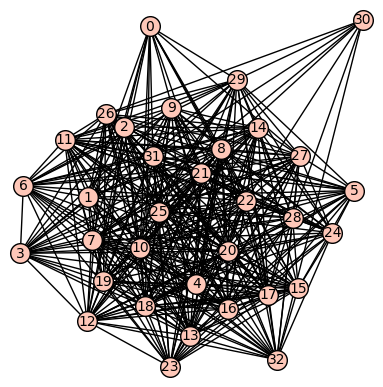

In [11]:
FG.show()

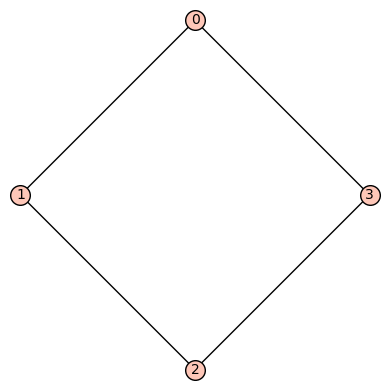

In [6]:
G=graphs.CycleGraph(4)
G.show()

In [7]:
All_Forts(G)

[[0, 2], [1, 3], [0, 2, 3], [0, 1, 3], [1, 2, 3], [0, 1, 2], [0, 1, 2, 3]]

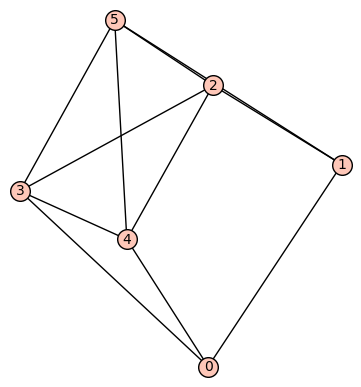

In [8]:
FG=Fort_RGraph(G)
FG.show()

In [9]:
m=FG.clique_number()

In [13]:
#the set of circuits correspond to the set of minimal forts in a compatible collection


AllBaseSets=[]

for k in range(1,m+1):
    C=CompCollForts(G,k,data_type='string')
    for c in C:
        M=Matroid(groundset='0123',circuits=c)
        B=sorted([sorted(b) for b in M.bases()])
        Bstr=[]
        for base in B:
            b=''
            for v in base:
                b=b+v
            Bstr.append(b)
            AllBaseSets.append(b)
        print 'rank of matroid: ', M.rank()
        print 'circuits: ', c
        #print 'bases: ', Bstr
        print '========================================================================'


rank of matroid:  3
circuits:  ['02']
rank of matroid:  3
circuits:  ['13']
rank of matroid:  3
circuits:  ['023']
rank of matroid:  3
circuits:  ['013']
rank of matroid:  3
circuits:  ['123']
rank of matroid:  3
circuits:  ['012']
rank of matroid:  3
circuits:  ['0123']
rank of matroid:  2
circuits:  ['02', '13']
rank of matroid:  2
circuits:  ['13', '023', '012']
rank of matroid:  2
circuits:  ['02', '013', '123']
rank of matroid:  2
circuits:  ['023', '013', '123', '012']


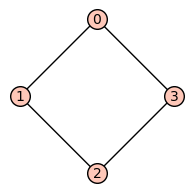

In [17]:
G.show(figsize=(2,2))

In [14]:
B=Matrix([[1,0,2,0],
         [0,1,0,3]])
B

[1 0 2 0]
[0 1 0 3]

In [49]:
var('a11,a12,a13,a14,a15,a16,a17,a18')
var('a21,a22,a23,a24,a25,a26,a27,a28')
var('a31,a32,a33,a34,a35,a36,a37,a38')
var('a41,a42,a43,a44,a45,a46,a47,a48')
var('a51,a52,a53,a54,a55,a56,a57,a58')
var('a61,a62,a63,a64,a65,a66,a67,a68')
var('a71,a72,a73,a74,a75,a76,a77,a78')
var('a81,a82,a83,a84,a85,a86,a87,a88')

A=Matrix([[a11,a12,a13,0,0,0,0,0],
         [a21,a22,0,a24,0,0,0,0],
         [a31,0,a33,a34,0,0,0,0],
         [0,a42,a43,a44,a45,a46,a47,0],
         [0,0,0,a54,a55,a56,a57,0],
         [0,0,0,a64,a65,a66,0,a68],
         [0,0,0,a74,a75,0,a77,a78],
         [0,0,0,0,0,a86,a87,a88]])

latex(A)



\left(\begin{array}{rrrrrrrr}
a_{11} & a_{12} & a_{13} & 0 & 0 & 0 & 0 & 0 \\
a_{21} & a_{22} & 0 & a_{24} & 0 & 0 & 0 & 0 \\
a_{31} & 0 & a_{33} & a_{34} & 0 & 0 & 0 & 0 \\
0 & a_{42} & a_{43} & a_{44} & a_{45} & a_{46} & a_{47} & 0 \\
0 & 0 & 0 & a_{54} & a_{55} & a_{56} & a_{57} & 0 \\
0 & 0 & 0 & a_{64} & a_{65} & a_{66} & 0 & a_{68} \\
0 & 0 & 0 & a_{74} & a_{75} & 0 & a_{77} & a_{78} \\
0 & 0 & 0 & 0 & 0 & a_{86} & a_{87} & a_{88}
\end{array}\right)

In [42]:
var('v2,v3,v5,v8')

v=Matrix([[0],[v2],[v3],[0],[v5],[0],[0],[v8]])
A*v

[        2*a12 + 3*a13]
[                2*a22]
[                3*a33]
[2*a42 + 3*a43 + 5*a45]
[                5*a55]
[          5*a65 + a68]
[          5*a75 + a78]
[                  a88]

In [47]:
A=Matrix([[a11,a12,-2/3*a12,0,0,0,0,0],
         [a21,0,0,a24,0,0,0,0],
         [a31,0,0,a34,0,0,0,0],
         [0,a42,a43,a44,(-2*a42-3*a43)/5,a46,a47,0],
         [0,0,0,a54,0,a56,-a56,0],
         [0,0,0,a64,a65,0,0,-5*a65],
         [0,0,0,a74,a75,0,0,-5*a75],
         [0,0,0,0,0,a86,-a86,0]])

A*v

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]

In [48]:
var('w1,w2,w3,w4,w5,w6,w7,w8')

w=Matrix([[0],[w2],[w3],[w4],[w5],[w6],[w7],[w8]])
A*w

[                                                a12*w1 - 2/3*a12*w2]
[                                                             a24*w3]
[                                                             a34*w3]
[a42*w1 + a43*w2 + a44*w3 - 1/5*(2*a42 + 3*a43)*w4 + a46*w5 + a47*w6]
[                                           a54*w3 + a56*w5 - a56*w6]
[                                         a64*w3 + a65*w4 - 5*a65*w7]
[                                         a74*w3 + a75*w4 - 5*a75*w7]
[                                                    a86*w5 - a86*w6]

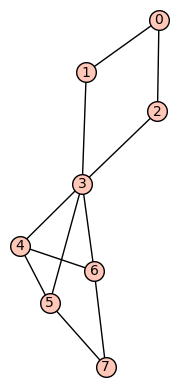

In [38]:
n=8
H=Graph([])
H.add_vertices(range(n))
for i in range(n):
    for j in range(i+1,n):
        if A[i][j] != 0:
            H.add_edge((i,j))

H.show()

In [39]:
All_Forts(H)

[[5, 6],
 [1, 2],
 [4, 6, 7],
 [0, 1, 2],
 [5, 6, 7],
 [4, 5, 6],
 [4, 5, 7],
 [0, 3, 4],
 [0, 3, 5, 7],
 [0, 1, 3, 4],
 [0, 3, 4, 7],
 [4, 5, 6, 7],
 [0, 3, 5, 6],
 [1, 2, 5, 6],
 [1, 2, 3, 4],
 [0, 2, 3, 4],
 [1, 2, 4, 7],
 [0, 3, 6, 7],
 [0, 1, 2, 5, 6],
 [0, 1, 3, 5, 7],
 [0, 3, 5, 6, 7],
 [0, 2, 3, 5, 6],
 [0, 2, 3, 4, 7],
 [0, 1, 3, 4, 7],
 [0, 3, 4, 6, 7],
 [0, 1, 2, 4, 7],
 [0, 3, 4, 5, 7],
 [1, 2, 4, 5, 6],
 [1, 2, 3, 6, 7],
 [0, 2, 3, 5, 7],
 [1, 2, 5, 6, 7],
 [0, 3, 4, 5, 6],
 [1, 2, 4, 5, 7],
 [0, 2, 3, 6, 7],
 [1, 2, 3, 5, 7],
 [1, 2, 4, 6, 7],
 [0, 1, 3, 6, 7],
 [1, 2, 3, 4, 7],
 [1, 2, 3, 5, 6],
 [0, 1, 2, 3, 4],
 [0, 1, 3, 5, 6],
 [0, 1, 2, 4, 5, 6],
 [0, 1, 2, 4, 6, 7],
 [0, 2, 3, 5, 6, 7],
 [1, 2, 3, 5, 6, 7],
 [0, 3, 4, 5, 6, 7],
 [0, 1, 2, 3, 5, 7],
 [0, 2, 3, 4, 5, 6],
 [0, 2, 3, 4, 5, 7],
 [0, 1, 3, 4, 5, 6],
 [1, 2, 3, 4, 6, 7],
 [0, 1, 2, 3, 6, 7],
 [1, 2, 4, 5, 6, 7],
 [0, 1, 2, 5, 6, 7],
 [0, 1, 2, 3, 5, 6],
 [0, 1, 2, 4, 5, 7],
 [0, 1, 2, 3, 4, 7],
 [1, 2, 3,

In [6]:
# bowtie example
################
################


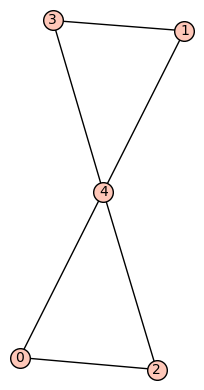

In [7]:
G=Graph('DQ{')
G.show()
# print 'Z(G) = ', find_Z(G)
# print 'Z+(G) = ', Zplus(G)


In [8]:
All_Forts(G)

[[0, 2],
 [1, 3],
 [1, 2, 4],
 [2, 3, 4],
 [0, 1, 4],
 [0, 3, 4],
 [1, 2, 3, 4],
 [0, 2, 3, 4],
 [0, 1, 2, 3],
 [0, 1, 2, 4],
 [0, 1, 3, 4],
 [0, 1, 2, 3, 4]]

In [9]:
len(All_Forts(G))

12

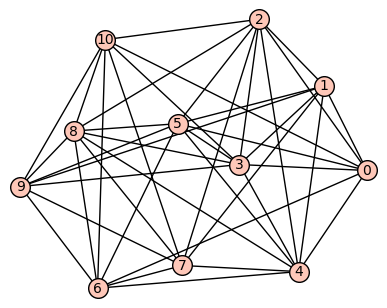

In [10]:
FG=Fort_RGraph(G)
FG.show()

In [11]:
m=FG.clique_number()

In [14]:
#the set of circuits correspond to the set of minimal forts in a compatible collection


AllBaseSets=[]

for k in range(1,m+1):
    C=CompCollForts(G,k,data_type='string')
    for c in C:
        M=Matroid(groundset='01234',circuits=c)
        B=sorted([sorted(b) for b in M.bases()])
        Bstr=[]
        for base in B:
            b=''
            for v in base:
                b=b+v
            Bstr.append(b)
            AllBaseSets.append(b)
        print 'rank of matroid: ', M.rank()
        print 'circuits: ', c
        print 'bases: ', Bstr
        print '==================================================================================='



rank of matroid:  4
circuits:  ['02']
bases:  ['0134', '1234']
rank of matroid:  4
circuits:  ['13']
bases:  ['0124', '0234']
rank of matroid:  4
circuits:  ['124']
bases:  ['0123', '0134', '0234']
rank of matroid:  4
circuits:  ['234']
bases:  ['0123', '0124', '0134']
rank of matroid:  4
circuits:  ['014']
bases:  ['0123', '0234', '1234']
rank of matroid:  4
circuits:  ['034']
bases:  ['0123', '0124', '1234']
rank of matroid:  4
circuits:  ['1234']
bases:  ['0123', '0124', '0134', '0234']
rank of matroid:  4
circuits:  ['0234']
bases:  ['0123', '0124', '0134', '1234']
rank of matroid:  4
circuits:  ['0123']
bases:  ['0124', '0134', '0234', '1234']
rank of matroid:  4
circuits:  ['0124']
bases:  ['0123', '0134', '0234', '1234']
rank of matroid:  4
circuits:  ['0134']
bases:  ['0123', '0124', '0234', '1234']
rank of matroid:  4
circuits:  ['01234']
bases:  ['0123', '0124', '0134', '0234', '1234']
rank of matroid:  3
circuits:  ['02', '13']
bases:  ['014', '034', '124', '234']
rank of ma